| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  | Stochastic volatility model |
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 02/29/20 |

In [106]:
# -- Load libraries --
# Data manipulation libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd

# Plotting libaries
import plotnine as pn
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

# Import PyMC3
from pymc3 import  *
# You will need to graphviz: "pip3 install graphviz"

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [107]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

Getting returns on S&P 500

In [110]:
import yfinance as yf
data = yf.download("^GSPC",'2015-01-01','2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [111]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


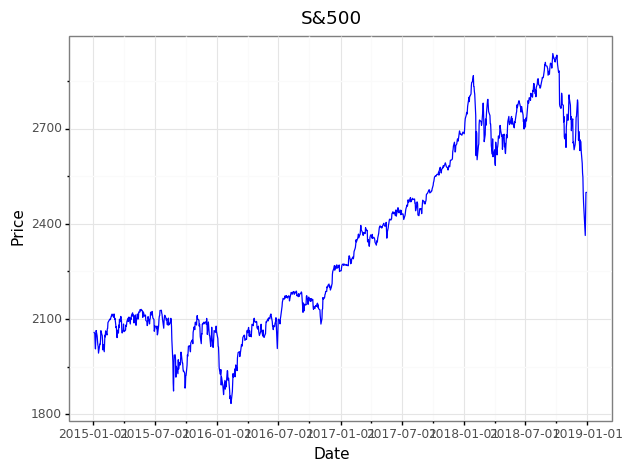

<ggplot: (-9223372036483678327)>

In [112]:
pn.options.figure_size=(7,5)
ggplot(aes(x = 'Date', y = 'Open'), data = data.reset_index()) + geom_line(color='blue') +theme_bw() +xlab('Date')+ylab('Price') + ggtitle('S&500')

In [113]:
# Calculating log(St/S_{t-1})
data["change"] = np.log(data["Close"]).diff()
data = data.dropna()
data = data.reset_index()


### Visualizing the data

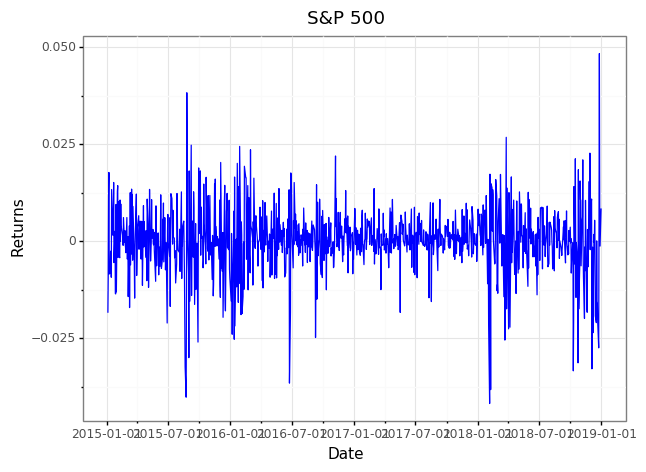

<ggplot: (370651151)>

In [114]:
ggplot(aes(x = 'Date', y = 'change'), data = data.reset_index()) + geom_line(color='blue') +theme_bw() +xlab('Date')+ylab('Returns') + ggtitle('S&P 500')

### Setting up NANs so that we can predict those values

In [115]:
data.loc[data.Date.between('2018-06-15','2018-12-31'),'change'] = np.NaN

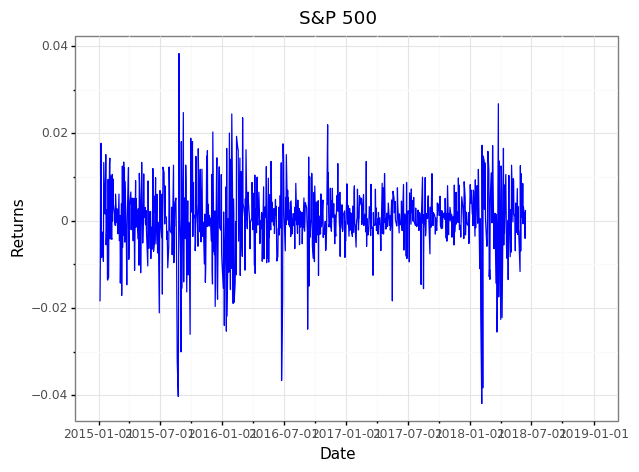

<ggplot: (-9223372036484062797)>

In [116]:
ggplot(aes(x = 'Date', y = 'change'), data = data.reset_index()) + geom_line(color='blue') +theme_bw() +xlab('Date')+ylab('Returns') + ggtitle('S&P 500')

#### We can represent a stochastic volatility model as:
$$
\sigma\sim Exp(50)\\
\nu\sim Exp(0.1)\\
s_i\sim N(s_{i-1},\sigma^{-2})\\
\log(r_i)\sim t(\nu,0,\exp(-2s_i))
$$

#### Setting up the model as a function

In [117]:
def make_stochastic_volatility_model(data):
    with Model() as model:
        step_size = Exponential('step_size', 10)
        volatility = GaussianRandomWalk('volatility', sigma=step_size, shape=len(data))
        nu = Exponential('nu', 0.1)
        returns = StudentT('returns',
                        nu=nu,
                        lam=np.exp(-2*volatility),
                        observed=data["change"])
    return model

stochastic_vol_model = make_stochastic_volatility_model(data)


What does the prior look like?
- Note that there can be a lot of volatility with the way we've specified the process

### Sampling the prior

In [118]:
with stochastic_vol_model:
    prior = sample_prior_predictive(20)

# Checking to see the variation of the prior - we'll do better!
data['prior_sample'] = prior['returns'][10:11,:].flatten() # one sample draw
ggplot(aes(x = 'Date', y = 'prior_sample'), data = data.reset_index()) + geom_line(color='red') +theme_bw() +xlab('Date')+ylab('Sample returns') + ggtitle('S&P 500')

# Max simulated value:
max_observed, max_simulated = np.max(np.abs(data['change'])), np.max(np.abs(prior['returns']))
print(f"Maximum observed in data: {max_observed:.2g}\nMaximum simulated return: {max_simulated:.2g}(!)")

Maximum observed in data: 0.042
Maximum simulated return: 1.6e+46(!)


#### Running the model

In [119]:
with stochastic_vol_model:
    trace = sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [returns_missing, nu, volatility, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [04:27<00:00, 59.83draws/s]
The acceptance probability does not match the target. It is 0.6669460993176495, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [120]:
summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
volatility[0],-4.500,0.262,-4.998,-4.008,0.006,0.004,1886.0,1886.0,1969.0,3739.0,1.00
volatility[1],-4.516,0.251,-5.012,-4.067,0.005,0.004,2112.0,2112.0,2147.0,4997.0,1.00
volatility[2],-4.529,0.242,-4.998,-4.086,0.005,0.003,2562.0,2562.0,2597.0,4532.0,1.00
volatility[3],-4.541,0.233,-4.972,-4.096,0.005,0.003,2556.0,2556.0,2640.0,3741.0,1.00
volatility[4],-4.571,0.229,-4.989,-4.130,0.004,0.003,3326.0,3326.0,3440.0,3557.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
returns_missing[134],0.001,0.023,-0.028,0.026,0.000,0.000,3798.0,1120.0,7699.0,367.0,1.06
returns_missing[135],-0.000,0.023,-0.030,0.026,0.000,0.001,3459.0,408.0,8553.0,309.0,1.08
returns_missing[136],-0.001,0.018,-0.028,0.026,0.000,0.001,2924.0,414.0,6482.0,347.0,1.07
step_size,0.101,0.019,0.064,0.136,0.002,0.002,69.0,69.0,69.0,158.0,1.04


### Generate posterior predictives

100%|██████████| 8000/8000 [00:05<00:00, 1422.06it/s]


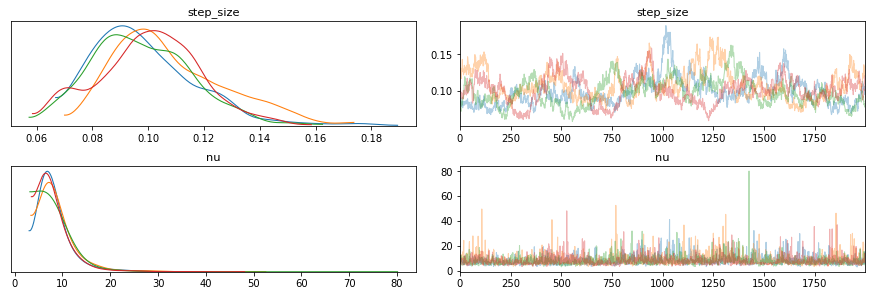

In [121]:
with stochastic_vol_model:
    posterior_predictive = sample_posterior_predictive(trace)
traceplot(trace, var_names=['step_size', 'nu']);

In [122]:
#np.exp(trace['volatility'])[::5].T
ci_ppd = pd.DataFrame(np.exp(trace['volatility'])[::5]).quantile([0.025,0.5, 0.975],axis=0).T.rename({0.025:'ci_lower',0.5:'median', 0.975:'ci_upper'},axis=1)

In [123]:
updated_data = pd.concat([data,ci_ppd], axis=1)


### Plotting volatility and 95% credible interval

In [124]:
updated_data

,Date,Open,High,Low,Close,Adj Close,Volume,change,prior_sample,ci_lower,median,ci_upper
0,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,-0.018447,-0.542481,0.006753,0.011089,0.018331
1,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,-0.008933,0.247008,0.007022,0.010968,0.018077
2,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,0.011563,1.369625,0.006809,0.010824,0.017747
3,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,0.017730,-0.172333,0.006910,0.010674,0.016717
4,2015-01-09,2063.449951,2064.429932,2038.329956,2044.810059,2044.810059,3364140000,-0.008439,0.935736,0.006768,0.010364,0.016042
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613930000,NaN,0.571732,0.000443,0.004997,0.048880
1001,2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4233990000,NaN,3.545537,0.000448,0.005033,0.046969
1002,2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000,NaN,0.431799,0.000429,0.004965,0.046888
1003,2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000,NaN,-1.246529,0.000418,0.005025,0.048055


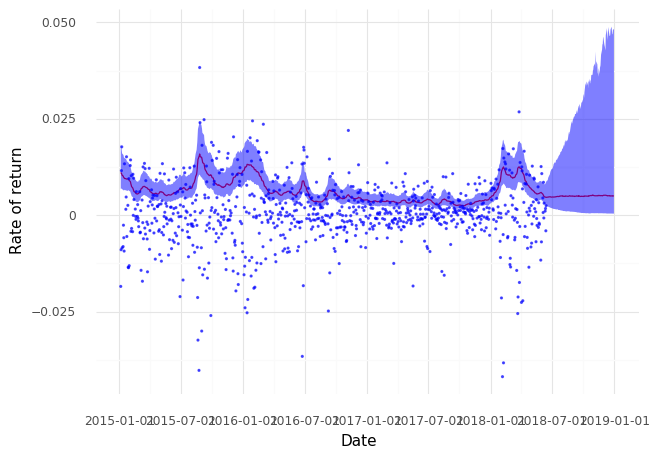

<ggplot: (345092605)>

In [128]:
ggplot(aes(x = 'Date',y = 'median'), data = updated_data)\
+ geom_line(color='red')\
+ geom_point(aes(x = 'Date', y = 'change'), size = 0.3, alpha = 0.6, color='blue')\
+ theme_minimal() + ylab('Rate of return') + xlab('Date')\
+ geom_ribbon(aes(x='Date', ymin='ci_lower',ymax='ci_upper'), fill="blue", alpha=0.5)

NameError: name 'returns' is not defined

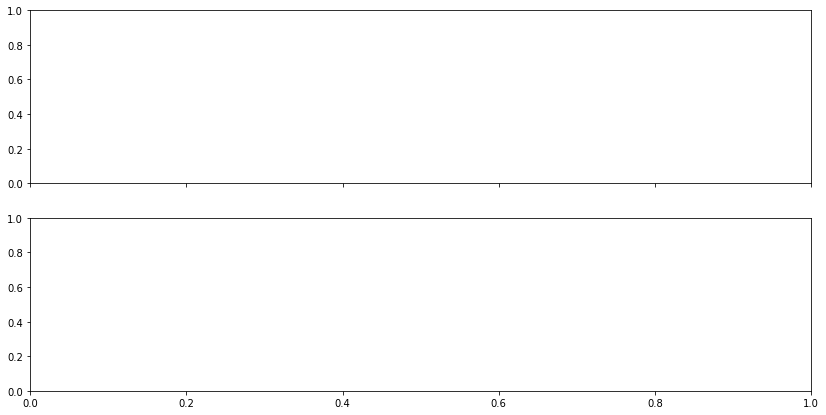

In [45]:
import scipy.stats as stats
    
def generate_proj_returns(burn_in, trace, len_to_train):
    num_pred = 1000
    mod_returns = np.ones(shape = (num_pred,len_to_train))
    vol = np.ones(shape = (num_pred,len_to_train))
    for k in range(0,num_pred):
        nu = trace[burn_in+k]['nu']
        mu = trace[burn_in+k]['mu']
        sigma = trace[burn_in+k]['sigma']
        s = trace[burn_in+k]['logs'][-1]        
        for j in range(0,len_to_train):
            cur_log_return, s = _generate_proj_returns( mu,
                                                        s, 
                                                        nu,
                                                        sigma)
            mod_returns[k,j] = cur_log_return
            vol[k,j] = s
    return mod_returns, vol

def _generate_proj_returns(mu,volatility, nu, sig):
    next_vol = np.random.normal(volatility, scale=sig) #sig is SD

    # Not 1/np.exp(-2*next_vol), scale treated differently in scipy than pymc3
    log_return = stats.t.rvs(nu, mu, scale=np.exp(-1*next_vol))
    return log_return, next_vol

sim_returns, vol = generate_proj_returns(1000,trace,len(test))

####  An alternate formulation
The formulation below reduces the noise and uses a normal model for observed changes
$$

$$

In [ ]:

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    nu = pm.Exponential('nu', 1./10)
    beta = pm.GaussianRandomWalk('beta',sigma**-2,shape=len(data['change']))
    observed = pm.Normal('observed', mu=beta*df['lag'], sd = 1/nu, observed = data['change'])
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [04:08<00:00, 64.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


100%|██████████| 8000/8000 [00:06<00:00, 1247.32it/s]


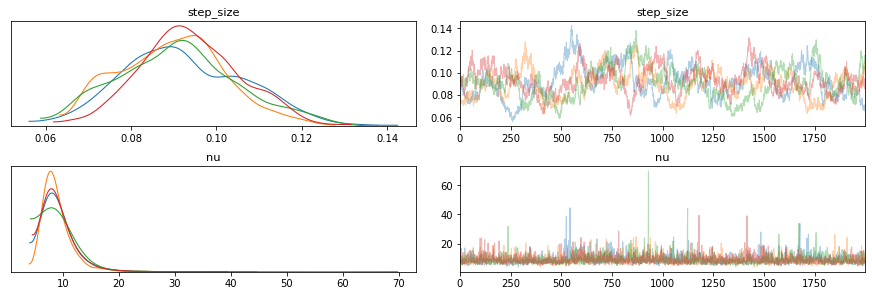

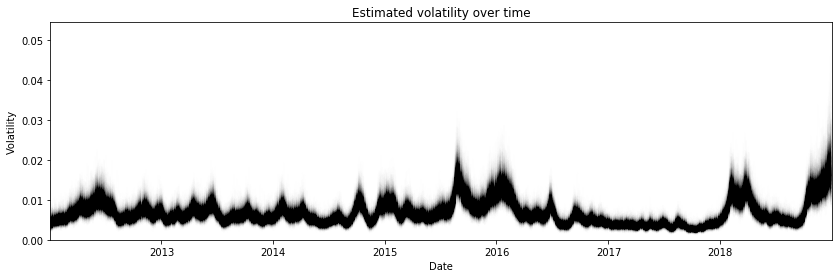

In [68]:
pd.DataFrame(np.exp(trace['volatility'][0:1,:].T))

,0
0,0.006702
1,0.006939
2,0.006471
3,0.006368
4,0.006209
...,...
1754,0.011035
1755,0.014319
1756,0.015249
1757,0.014971


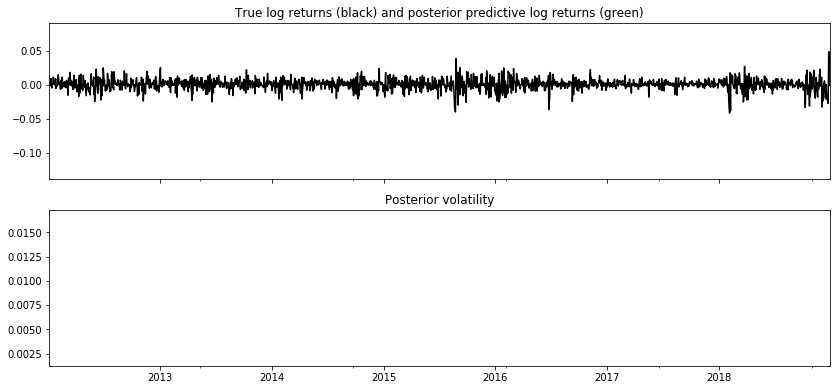

In [71]:
posterior_predictive['returns'][::100].T

array([[-0.0012184 , -0.00119385, -0.00333952, ...,  0.0036328 ,
         0.0050998 , -0.00375442],
       [-0.00401714, -0.00617812, -0.00066845, ...,  0.00078992,
         0.01103088, -0.00506207],
       [ 0.0078642 , -0.00577653,  0.00506552, ..., -0.00406792,
        -0.00161901,  0.00381867],
       ...,
       [-0.00034115, -0.02474961, -0.00632107, ...,  0.00527645,
        -0.02230572, -0.0127509 ],
       [-0.03251126, -0.01792073, -0.02620969, ..., -0.01375943,
        -0.06275803, -0.00851207],
       [ 0.00751381,  0.00282094,  0.03548548, ...,  0.01272112,
        -0.00949203,  0.03027533]])